In [ ]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

Dataset used from kaggle: [Click Here](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data)

In [ ]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df = df.drop(['HbA1c_level', 'blood_glucose_level'], axis=1)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0


In [ ]:
gender_to_num = {
    'Female': 1.0,
    'Male': -1.0,
    'Other': 0.0
}
df['gender_processed'] = df['gender'].apply(lambda x: gender_to_num[x])
df.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes,gender_processed
0,Female,80.0,0,1,never,25.19,0,1.0
1,Female,54.0,0,0,No Info,27.32,0,1.0
2,Male,28.0,0,0,never,27.32,0,-1.0
3,Female,36.0,0,0,current,23.45,0,1.0
4,Male,76.0,1,1,current,20.14,0,-1.0


In [ ]:
smoking_history_to_num = {
    'never': 0.0,
    'not current': 1.0,
    'No Info': 2.0,
    'current': 3.0,
    'former': 4.0,
    'ever':5.0
}
df['smoking_history_processed'] = df['smoking_history'].apply(
    lambda x: smoking_history_to_num[x])
df.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes,gender_processed,smoking_history_processed
0,Female,80.0,0,1,never,25.19,0,1.0,0.0
1,Female,54.0,0,0,No Info,27.32,0,1.0,2.0
2,Male,28.0,0,0,never,27.32,0,-1.0,0.0
3,Female,36.0,0,0,current,23.45,0,1.0,3.0
4,Male,76.0,1,1,current,20.14,0,-1.0,3.0


In [ ]:
df_processed = df[[
    'age', 'hypertension', 'heart_disease', 'bmi', 'gender_processed', 'smoking_history_processed',
    'diabetes'
]].astype(float)
df_processed.head()

,age,hypertension,heart_disease,bmi,gender_processed,smoking_history_processed,diabetes
0,80.0,0.0,1.0,25.19,1.0,0.0,0.0
1,54.0,0.0,0.0,27.32,1.0,2.0,0.0
2,28.0,0.0,0.0,27.32,-1.0,0.0,0.0
3,36.0,0.0,0.0,23.45,1.0,3.0,0.0
4,76.0,1.0,1.0,20.14,-1.0,3.0,0.0


In [ ]:
positive_ = df_processed[df_processed.diabetes == 1]
negative_ = df_processed[df_processed.diabetes == 0]

In [ ]:
def plot_feature_vs_label(df, feature_col, label_col='diabetes'):
    bins = np.linspace(
        df[feature_col].min(), df[feature_col].max(), 10)
    plt.figure(figsize=(6, 4))
    positive = df[df[label_col] == 1.0]
    negative = df[df[label_col] != 1.0]

    plt.hist(positive[feature_col].tolist(), bins, alpha=0.4, label=label_col)
    plt.hist(negative[feature_col].tolist(), bins, alpha=0.4, label=f'non-{label_col}')
    plt.legend(loc='upper right')
    plt.xlabel(feature_col)
    plt.ylabel('count')
    plt.title(f'diabetes vs {feature_col}')
    plt.show()

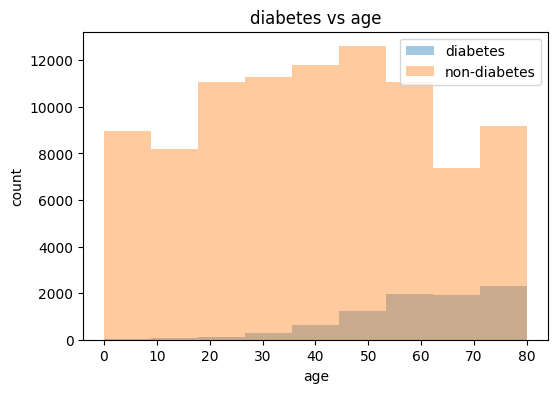

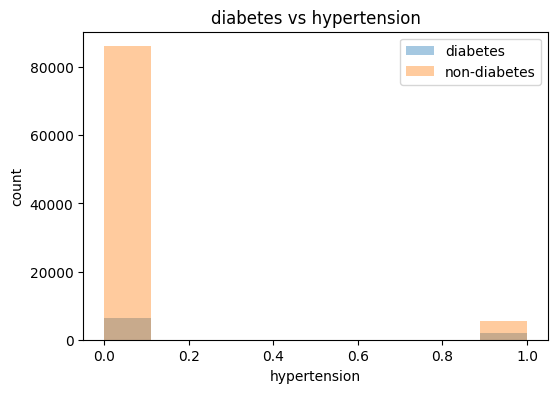

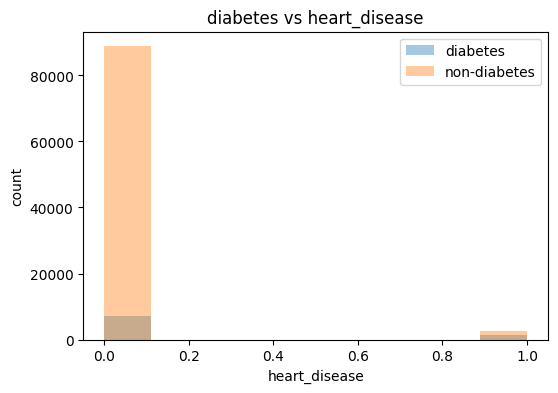

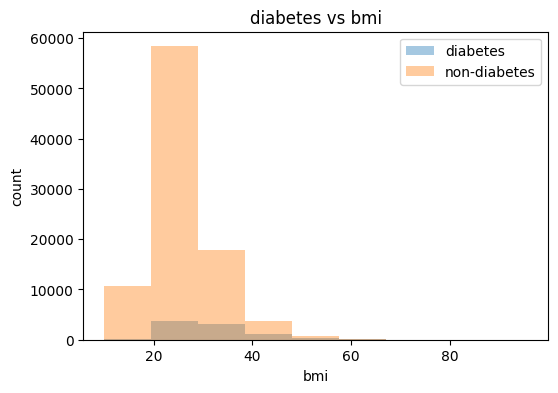

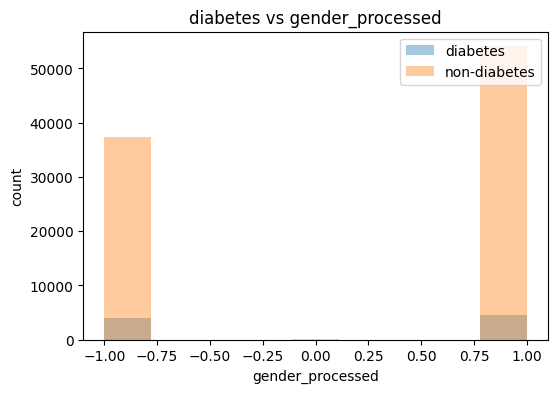

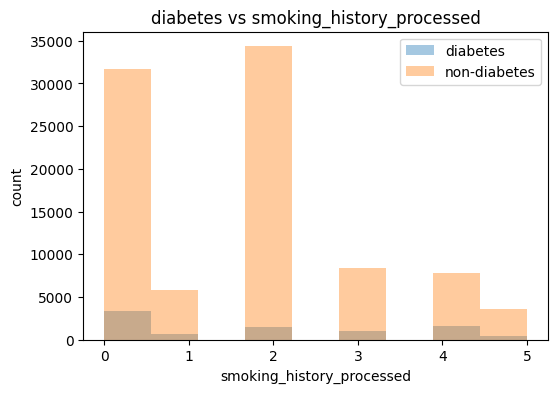

In [ ]:
for col in df_processed.columns:
    if col != 'diabetes':
        plot_feature_vs_label(
            df=df_processed, feature_col=col, label_col='diabetes')

In [ ]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(
    df_processed, test_size=0.3, random_state=7)
print(train.shape)
print(valid.shape)

(70000, 7)
(30000, 7)


In [ ]:
feature_cols = [
    'age', 'hypertension', 'heart_disease', 'bmi', 'gender_processed', 'smoking_history_processed'
]
label_col = 'diabetes'

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(train[feature_cols], train[label_col])

LogisticRegression()

In [ ]:
logisticRegrRes = pd.DataFrame({
    'pred': logisticRegr.predict(valid[feature_cols]),
    'probability': logisticRegr.predict_proba(valid[feature_cols])[:, 1],
    'label': valid[label_col]
})
logisticRegrRes.head()

,pred,probability,label
33909,0.0,0.149166,0.0
92307,0.0,0.005734,0.0
89107,0.0,0.036315,0.0
9538,0.0,0.069964,0.0
31008,1.0,0.708779,0.0


In [ ]:
from sklearn.metrics import auc, roc_auc_score, precision_recall_curve

def get_metrics(results_df):
    precision, recall, thresholds = precision_recall_curve(
        results_df['label'], results_df['probability'])
    auprc = auc(recall, precision)
    auroc = roc_auc_score(
        results_df['label'], results_df['probability'])
    accuracy = (results_df['pred'] == results_df['label']).astype(
        float).sum() / results_df.shape[0]
    baseline_accuracy = (logisticRegrRes['label'] == 0).astype(
        float).sum() / logisticRegrRes.shape[0]
    return {
        'auprc': auprc,
        'auroc': auroc,
        'accuracy': accuracy,
        'baseline_accuracy': baseline_accuracy
    }

In [ ]:
get_metrics(logisticRegrRes)

{'auprc': 0.30828408908432736,
 'auroc': 0.8286364687935853,
 'accuracy': 0.9144,
 'baseline_accuracy': 0.9143666666666667}

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def normalize_feature_values(df, df_train, feature_cols):
    df = pd.DataFrame(df)
    for col in feature_cols:
        df[col] = (df[col] - df_train[col].min()) / (
            df_train[col].max() - df_train[col].min())
    return df
train_nomalized = normalize_feature_values(train, train, feature_cols)
valid_nomalized = normalize_feature_values(valid, train, feature_cols)

In [ ]:
N_COMP = 6
PCA_FEATURES = [f'pc{i+1}' for i in range(N_COMP)]

class PCATransformer:

    def __init__(
        self, n_components_, train_df_,
        feature_cols_, target_col_, normalize_=True):
        self._pca = PCA(n_components=n_components_)
        self._pca_cols = [f'pc{i+1}' for i in range(n_components_)]
        self._feature_cols = feature_cols_
        self._target_col = target_col_
        self._is_normalize = normalize_
        self._data = pd.DataFrame(train_df_)
        if self._is_normalize:
            train_df_ = self._normalize(train_df_)
            self._pca.fit(train_df_[self._feature_cols])

    def _normalize(self, df):
        df_ = pd.DataFrame(df)
        for col in self._feature_cols:
            df_[col] = (
                df_[col] - self._data[col].min()) / (
                self._data[col].max() - self._data[col].min())
        return df_

    def transform(self, df):
        if self._is_normalize:
            df = self._normalize(df)
        transformed_data = self._pca.transform(df[self._feature_cols])
        transformed_df = pd.DataFrame(
            data=transformed_data,
            columns=self._pca_cols)
        transformed_df[self._target_col] = df[self._target_col].tolist()
        return transformed_df

In [ ]:
pca_transformer = PCATransformer(N_COMP, train, feature_cols, label_col, normalize_=True)
train_pca = pca_transformer.transform(train)
valid_pca = pca_transformer.transform(valid)

In [ ]:
train_pca.head(5)

,pc1,pc2,pc3,pc4,pc5,pc6,diabetes
0,-0.420197,-0.254251,-0.000281,0.075399,0.042100,0.027066,0.0
1,-0.357009,0.303572,0.646170,-0.041703,-0.074635,-0.026454,0.0
2,-0.400180,-0.271662,0.214035,0.167464,0.064489,0.035181,0.0
3,-0.397909,-0.347441,0.240460,0.222913,0.090917,-0.099585,0.0
4,0.551098,-0.121043,-0.345142,-0.155146,-0.064490,-0.008404,0.0


In [ ]:
logisticRegrPCA = LogisticRegression()
logisticRegrPCA.fit(train_pca[PCA_FEATURES], train_pca[label_col])
logisticRegrPCARes = pd.DataFrame({
    'pred': logisticRegrPCA.predict(valid_pca[PCA_FEATURES]),
    'probability': logisticRegrPCA.predict_proba(valid_pca[PCA_FEATURES])[:, 1],
    'label': valid_pca[label_col]
})
get_metrics(logisticRegrPCARes)

{'auprc': 0.3080989753193704,
 'auroc': 0.828730593634002,
 'accuracy': 0.9145,
 'baseline_accuracy': 0.9143666666666667}

In [ ]:
import pickle

In [ ]:
pickle_out = open("model.pkl", mode = "wb")
pickle.dump(logisticRegrPCA, pickle_out)
pickle_out.close()

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.2 MB/s eta 0:00:00


In [76]:
%%writefile app.py
#import libs
import streamlit as st
import tensorflow as tf
import random
import numpy as np

import pickle

# hide deprication warnings which directly don't affect the working of the application
import warnings
warnings.filterwarnings("ignore")

# set some pre-defined configurations for the page, such as the page title, logo-icon, page loading state (whether the page is loaded automatically or you need to perform some action for loading)
st.set_page_config(
    page_title="Pre-Diabetic Screening Test",
    page_icon = ":smile:",
    initial_sidebar_state = 'auto'
)

custom_css = """
<style>
/* Main content background color - light blue */
.main .block-container { background-color: #add8e6; }
/* Sidebar background color - darker blue */
.sidebar .sidebar-content { background-color: #87ceeb; }
/* Text color - dark blue for all elements inside main container */
.main .block-container * { color: #00008b; }
/* Button color - adjust accordingly */
.stButton>button { background-color: #0000ff; border: none; color: white; }
/* Input and select box colors */
.stTextInput>input, .stSlider>input, .stSelectbox>select { color: #00008b; } /* Text color for inputs and sliders */
/* Specific color for selectbox options */
.stSelectbox option { color: #add8e6; } /* Change this to #add8e6 for light blue, or keep white */
/* Radio button colors */
.stRadio>label { color: #00008b; }
/* Hide streamlit menu and footer */
#MainMenu {visibility: hidden;}
footer {visibility: hidden;}

</style>
"""
st.markdown(custom_css, unsafe_allow_html=True)  # Apply custom CSS

st.sidebar.image('./Screenshot__7_-removebg-preview.png')



# hide the part of the code, as this is just for adding some custom CSS styling but not a part of the main idea
hide_streamlit_style = """
	<style>
  #MainMenu {visibility: hidden;}
	footer {visibility: hidden;}
  </style>
"""
st.markdown(hide_streamlit_style, unsafe_allow_html=True) # hide the CSS code from the screen as they are embedded in markdown text. Also, allow streamlit to unsafely process as HTML

with st.sidebar:
        st.title("Diabetes Information")
        st.subheader("Diabetes is a chronic medical condition that affects how your body processes glucose, a type of sugar, which is a crucial source of energy for cells.")

st.write("""
         # Pre-Diabetic Prevention!
         """
         )

#load model
pickle_in = open('model.pkl', 'rb')
classifier = pickle.load(pickle_in)

@st.cache

def prediction(gender, age, hypertension, heart_disease, smoking_history, bmi):
  if gender == 'Female':
    gender = 1
  elif gender == 'Male':
    gender = -1
  else:
    gender = 0

  age = age

  if hypertension == 'Yes':
    hypertension = 1
  else:
    hypertension = 0

  if heart_disease == 'Yes':
    heart_disease = 1
  else:
    heart_disease = 0

  if smoking_history == 'Never':
    smoking_history = 0
  elif smoking_history == 'Not Current':
    smoking_history = 1
  elif smoking_history == 'No Info':
    smoking_history = 2
  elif smoking_history == 'Current':
    smoking_history = 3
  elif smoking_history == 'Former':
    smoking_history = 4
  elif smoking_history == 'Ever':
    smoking_history = 5
  else:
    smoking_history = 2

  bmi = bmi

  prediction = classifier.predict([[gender, age, hypertension, heart_disease, smoking_history, bmi]])
  return prediction

gender = st.selectbox('What is your gender?', ('Female', 'Male', 'Other'))

age = st.number_input("What is your Age?", placeholder='type age here')

hypertension = st.radio('Do you have hypertension?', ['Yes', 'No'])

heart_disease = st.radio('Do you have heart disease', ['Yes', 'No'])

smoking_history = st.radio('What is your history with smoking?', ['Never', 'Not Current', 'No Info', 'Current', 'Former', 'Ever'])

st.write('What is your BMI?')
bmi = st.slider('BMI Input', 10, 98, 40)

predict = ''

if st.button("See Results!"):
    predict = prediction(gender, age, hypertension, heart_disease, smoking_history, bmi)
    st.write(predict)

    if(predict == 1):
      st.sidebar.warning('High Risk of Diabetes')
      st.markdown("#May be prone to presence of diabetes")
      st.info("Seek medical attention as soon as possible and please get screened!")
      st.info("Look into taking the a1c test for hemoglobin levels to get better results from your doctor")
    else:
      st.balloons()
      st.sidebar.success('You are healthy!')
      st.info("While our model does say your are healthy, it is better to get screened by your doctor for safer measures!")


Overwriting app.py


In [56]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.453s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [77]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

104.196.105.127
npx: installed 22 in 3.516s
your url is: https://six-dolls-wink.loca.lt
